In [1]:
import io
import base64
from twelvedata import TDClient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import base64
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from numpy import array
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math

In [2]:
def get_data():
    td = TDClient(apikey="b75cd7ff4895430983a1079da81382ac")
    ts = td.time_series(
        symbol= "INFY",
        interval="1day",
        outputsize= 1242,
        timezone="Asia/Kolkata",
    )
    df = ts.as_pandas()
    return df
df = get_data()
df = df.sort_values(by='datetime',ascending=True)


In [3]:
df.head()

open   high    low  close    volume
datetime                                        
2018-01-26  9.250  9.275  9.165  9.250   7542800
2018-01-29  9.285  9.335  9.250  9.275  12540800
2018-01-30  9.115  9.185  9.090  9.125  12589400
2018-01-31  9.125  9.130  8.975  9.005  19138600
2018-02-01  9.045  9.045  8.925  8.965  10878600

In [4]:
df1 = df.reset_index()['close']

In [5]:
df1.head()

0    9.250
1    9.275
2    9.125
3    9.005
4    8.965
Name: close, dtype: float64

In [6]:
df1 = df1.astype(int)

In [7]:
df1.head()

0    9
1    9
2    9
3    9
4    8
Name: close, dtype: int32

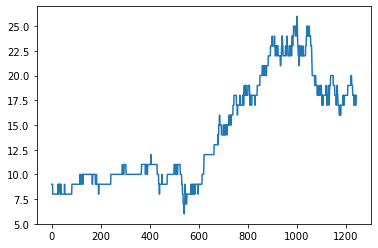

In [8]:
%matplotlib inline
plt.plot(df1)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
df1

array([[0.15],
       [0.15],
       [0.15],
       ...,
       [0.55],
       [0.6 ],
       [0.6 ]])

In [11]:
## Spliting the data into train test split
trainig_size = int(len(df1)*0.65)
test_size = len(df1)-trainig_size
train_data,test_data = df1[0:trainig_size,:],df1[trainig_size:len(df1),:1]

In [12]:
len(train_data),len(test_data)

(807, 435)

In [13]:
import numpy
def create_dataset(dataset,time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]  ##i = 0,1,2,3
        dataX.append(a)
        dataY.append(dataset[i + time_step,0])
    return numpy.array(dataX),numpy.array(dataY)

In [14]:
## Reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data,time_step)
X_test, y_test = create_dataset(test_data,time_step)

In [15]:
print(X_train.shape),print(y_train.shape)

(706, 100)
(706,)


(None, None)

In [16]:
# reshape input to be (samples,time steps,features) which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [17]:
## Create the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [18]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose = 1)


Epoch 1/100
12/12 [==============================] - 18s 464ms/step - loss: 0.0269 - val_loss: 0.0504
Epoch 2/100
12/12 [==============================] - 3s 236ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 3/100
12/12 [==============================] - 3s 228ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 4/100
12/12 [==============================] - 3s 220ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 5/100
12/12 [==============================] - 3s 220ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 6/100
12/12 [==============================] - 3s 225ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 7/100
12/12 [==============================] - 3s 226ms/step - loss: 0.0013 - val_loss: 0.0080
Epoch 8/100
12/12 [==============================] - 3s 227ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 9/100
12/12 [==============================] - 3s 228ms/step - loss: 0.0016 - val_loss: 0.0045
Epoch 10/100
12/12 [==============================] - 3s 228ms/step - loss: 0.0013 - val_l

In [133]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_16 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [134]:
## lets do the prediction and check performance metrcis
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 20ms/step


In [135]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [136]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

11.046867260722985

In [137]:
math.sqrt(mean_squared_error(y_test,test_predict))

19.752780054635622

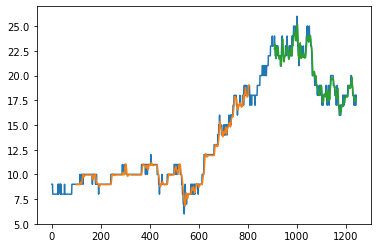

In [138]:
## Plotting
# shift train predictions for plotting
look_back = 100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [139]:
len(test_data)

435

In [140]:
x_input = test_data[335:].reshape(1,-1)
x_input.shape

(1, 100)

In [141]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [142]:
temp_input

[0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.55,
 0.6,
 0.6,
 0.65,
 0.65,
 0.6,
 0.6,
 0.55,
 0.55,
 0.55,
 0.55,
 0.55,
 0.5,
 0.5,
 0.5,
 0.5,
 0.55,
 0.5,
 0.5,
 0.55,
 0.55,
 0.55,
 0.55,
 0.55,
 0.55,
 0.55,
 0.55,
 0.6,
 0.55,
 0.6,
 0.6,
 0.55,
 0.55,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.65,
 0.7,
 0.7,
 0.7,
 0.65,
 0.65,
 0.65,
 0.65,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.55,
 0.55,
 0.6,
 0.6,
 0.55,
 0.55,
 0.6,
 0.55,
 0.6,
 0.6]

In [143]:
## Demonstrate predictions for next 10 da
from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i<30):
    
    if (len(temp_input)>100):
        #print(temp_input)
        x_input = np.array(temp_input[1:])
        print('{} day input {}'.format(i,x_input))
        x_input = x_input.reshape((1,n_steps,1))
        #print(x_input)
        yhat = model.predict(x_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input,verbose = 0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i+1
    
print(lst_output)
        

[0.5858492]
101
1 day input [0.7        0.7        0.7        0.7        0.7        0.65
 0.65       0.65       0.65       0.65       0.65       0.6
 0.6        0.6        0.6        0.6        0.6        0.55
 0.6        0.6        0.65       0.65       0.6        0.6
 0.55       0.55       0.55       0.55       0.55       0.5
 0.5        0.5        0.5        0.55       0.5        0.5
 0.55       0.55       0.55       0.55       0.55       0.55
 0.55       0.55       0.6        0.55       0.6        0.6
 0.55       0.55       0.6        0.6        0.6        0.6
 0.6        0.6        0.6        0.6        0.6        0.6
 0.6        0.6        0.6        0.6        0.65       0.65
 0.65       0.65       0.65       0.65       0.65       0.65
 0.65       0.65       0.65       0.65       0.65       0.7
 0.7        0.7        0.65       0.65       0.65       0.65
 0.6        0.6        0.6        0.6        0.6        0.55
 0.55       0.6        0.6        0.55       0.55       0.6
 0.55

8 day output [[0.5715208]]
9 day input [0.65       0.65       0.65       0.6        0.6        0.6
 0.6        0.6        0.6        0.55       0.6        0.6
 0.65       0.65       0.6        0.6        0.55       0.55
 0.55       0.55       0.55       0.5        0.5        0.5
 0.5        0.55       0.5        0.5        0.55       0.55
 0.55       0.55       0.55       0.55       0.55       0.55
 0.6        0.55       0.6        0.6        0.55       0.55
 0.6        0.6        0.6        0.6        0.6        0.6
 0.6        0.6        0.6        0.6        0.6        0.6
 0.6        0.6        0.65       0.65       0.65       0.65
 0.65       0.65       0.65       0.65       0.65       0.65
 0.65       0.65       0.65       0.7        0.7        0.7
 0.65       0.65       0.65       0.65       0.6        0.6
 0.6        0.6        0.6        0.55       0.55       0.6
 0.6        0.55       0.55       0.6        0.55       0.6
 0.6        0.58584923 0.59067267 0.59135669 0.58974516

17 day output [[0.5536523]]
18 day input [0.55       0.6        0.6        0.65       0.65       0.6
 0.6        0.55       0.55       0.55       0.55       0.55
 0.5        0.5        0.5        0.5        0.55       0.5
 0.5        0.55       0.55       0.55       0.55       0.55
 0.55       0.55       0.55       0.6        0.55       0.6
 0.6        0.55       0.55       0.6        0.6        0.6
 0.6        0.6        0.6        0.6        0.6        0.6
 0.6        0.6        0.6        0.6        0.6        0.65
 0.65       0.65       0.65       0.65       0.65       0.65
 0.65       0.65       0.65       0.65       0.65       0.65
 0.7        0.7        0.7        0.65       0.65       0.65
 0.65       0.6        0.6        0.6        0.6        0.6
 0.55       0.55       0.6        0.6        0.55       0.55
 0.6        0.55       0.6        0.6        0.58584923 0.59067267
 0.59135669 0.58974516 0.58689743 0.58334744 0.57942802 0.57540929
 0.57152081 0.56794041 0.56478512 0.56

26 day output [[0.540172]]
27 day input [0.55       0.55       0.55       0.5        0.5        0.5
 0.5        0.55       0.5        0.5        0.55       0.55
 0.55       0.55       0.55       0.55       0.55       0.55
 0.6        0.55       0.6        0.6        0.55       0.55
 0.6        0.6        0.6        0.6        0.6        0.6
 0.6        0.6        0.6        0.6        0.6        0.6
 0.6        0.6        0.65       0.65       0.65       0.65
 0.65       0.65       0.65       0.65       0.65       0.65
 0.65       0.65       0.65       0.7        0.7        0.7
 0.65       0.65       0.65       0.65       0.6        0.6
 0.6        0.6        0.6        0.55       0.55       0.6
 0.6        0.55       0.55       0.6        0.55       0.6
 0.6        0.58584923 0.59067267 0.59135669 0.58974516 0.58689743
 0.58334744 0.57942802 0.57540929 0.57152081 0.56794041 0.56478512
 0.56210941 0.55991203 0.55814654 0.55673581 0.55558372 0.55458838
 0.55365229 0.55269051 0.55163604 

In [144]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [145]:
len(df1)

1242

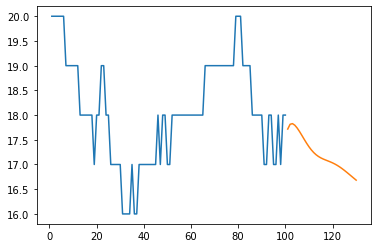

In [146]:
plt.plot(day_new,scaler.inverse_transform(df1[1142:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

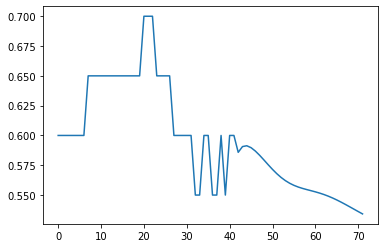

In [147]:
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])